# Coordinate Reference System 

CRS from [vts-registry/srs.json at master · Melown/vts-registry](https://github.com/Melown/vts-registry/blob/master/registry/registry/srs.json)


In [1]:
#CRS from  https://github.com/Melown/vts-registry/blob/master/registry/registry/srs.json
mercury_crs = {
    "geographic-dmercury2000": {
        "comment": "Geographic, DMercury2000 (iau2000:19900)",
        "srsDef": "+proj=longlat +a=2439700 +b=2439700 +no_defs",
        "type": "geographic"
    },
    "geocentric-dmercury2000": {
        "comment": "Geocentric, Mercury",
        "srsDef": "+proj=geocent +a=2439700 +b=2439700 +lon_0=0 +units=m +no_defs",
        "type": "cartesian"
    },
    "eqc-dmercury2000": {
        "comment": "Equidistant Cylindrical, DMercury2000 (iau2000:19911)",
        "srsDef": "+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=2439700 +b=2439700 +units=m +no_defs",
        "type": "projected"
    },
    "merc-dmercury2000": {
        "comment": "Mercator, DMercury2000 (iau2000:19974)",
        "srsDef": "+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=2439700 +b=2439700 +units=m +no_defs",
        "type": "projected"
    },
    "steren-dmercury2000": {
        "comment": "Polar Sterographic North, DMercury2000 (iau2000:19918)",
        "srsDef": "+proj=stere +lat_0=90 +lat_ts=90 +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=2439700 +b=2439700 +units=m +no_defs",
        "type": "projected"
    },
    "steres-dmercury2000": {
        "comment": "Polar Stereographic South, DMercury2000 (iau2000:19920)",
        "srsDef": "+proj=stere +lat_0=-90 +lat_ts=-90 +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=2439700 +b=2439700 +units=m +no_defs",
        "type": "projected"
}}

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon
import fiona
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
# from tqdm import tqdm
pd.set_option('max_colwidth',150)

In [3]:
# create the wavelenghts
wav_grid_2nm = np.arange(260,1052,2)

# define find_nearest, with wav_grid_2nm as default array
# note you can change the array, it is fixed at function creation time!!!
def find_nearest(value,array=wav_grid_2nm):
    return (np.abs(array - value)).argmin()

In [4]:
# define the datafile with filename structure:
# [description from database]_[function applied to the spectra for each pixel]_[data array used]
#     [description from database] = grid_2D_0_360_-90_+90
#     [function applied to the spectra for each pixel] = avg or st_median
#     [data array used] = iof_sp_2nm or photom_iof_sp_2nm

# outfile = 'grid_2D_-180_+180_-90_+90_1deg_avg_iof_sp_2nm'
# outfile = 'grid_2D_-180_+180_-90_+90_1deg_avg_photom_iof_sp_2nm'
# outfile = 'grid_2D_-180_+180_-90_+90_1deg_st_median_iof_sp_2nm'
# outfile = 'grid_2D_-180_+180_-90_+90_1deg_st_median_photom_iof_sp_2nm'
outfile = 'grid_2D_-180_+180_-90_+90_1deg_stddev_photom_iof_sp_2nm'

In [5]:
# Write : not working!
# write the Geopandas.GeoDataFrame to compressed json : Geopandas canno't handle this.
# import gzip
# with gzip.GzipFile(outfile+'.json.gz', 'wb') as fout:
#     fout.write(outdf_gdf[['poly', 'array']].to_json().encode('utf-8'))

# Read the data

The data are in a gzipped geojson to reduce size, but geopandas doesn't like it.

The function below accept a path and return a GeoDataFrame.

An optional `gzipped[=True default]` keywords take care of compressed geojson.

In [6]:
# Read method 2 : same as 1, but in a function
def get_mascs_geojson(file, gzipped=True):
    import json
    import gzip
    from geopandas import GeoDataFrame

    if gzipped:
        # get the compressed geojson
        with gzip.GzipFile(file, 'r') as fin:
            geodata = json.loads(fin.read().decode('utf-8'))
    else:
        # get the uncompressed geojson
        with open(file, 'r') as fin:
            geodata = json.load(fin)
            
    import shapely 
    # extract geometries
    geometries = [shapely.geometry.Polygon(g['geometry']['coordinates'][0]) for g in geodata['features']]
    # extract id
    ids = [int(g['id']) for g in geodata['features']]
    # generate GeoDataFrame
    out_gdf = gpd.GeoDataFrame(data=[g['properties'] for g in geodata['features']], geometry=geometries, index=ids).sort_index()
    # cast arrays to numpy
    out_gdf['array'] = out_gdf['array'].apply(lambda x: np.array(x).astype(np.float))
    
    return out_gdf

In [7]:
outdf_gdf = get_mascs_geojson(outfile+'.geojson.gz', gzipped=True)
# this is to be sure that the cells are ordered in natural way == reshape with numpy
outdf_gdf = outdf_gdf.set_index('natural_index',drop=True).sort_index()

# set Mercury Lat/Lon as crs
outdf_gdf.crs = fiona.crs.from_string(mercury_crs['geographic-dmercury2000']['srsDef'])

In [8]:
# some sample from the data, the columns are :
# polygon ID frm database
# calculated array of all spectra in this polygon
# geometry of the polygon.
outdf_gdf.head(10)

,array,geometry
natural_index,,
0,[],"POLYGON ((-180 90, -179 90, -179 89, -180 89, -180 90))"
1,"[0.0, 0.0, 0.0162367538033, 0.0309478144351, 0.0124240007609, 0.0378531956527, 0.0444937246557, 0.0229195306147, 0.0304128979761, 0.0414760800572,...","POLYGON ((-180 89, -179 89, -179 88, -180 88, -180 89))"
2,"[0.0, 0.0, 0.0284595150334, 0.02527397217, 0.0248321872112, 0.0265523497074, 0.0262212433401, 0.0105058385506, 0.00586713609565, 0.0319427983335, ...","POLYGON ((-180 88, -179 88, -179 87, -180 87, -180 88))"
3,"[0.0, 0.0, 0.0118588949341, 0.00594579299317, 0.00681718707585, 0.00631355898295, 0.00654642411565, 0.0119017889763, 0.0178238410147, 0.0091638469...","POLYGON ((-180 87, -179 87, -179 86, -180 86, -180 87))"
4,"[1.52083274458e+16, 0.0, 0.0196289590987, 0.0171081303168, 0.0120329973953, 0.0155640690233, 0.0161061009743, 0.0179978200228, 0.0234204710604, 0....","POLYGON ((-180 86, -179 86, -179 85, -180 85, -180 86))"
5,"[1.81834346486e+16, 0.0, 0.0936709931521, 0.0678607138115, 0.061789693565, 0.0677108618282, 0.0799777070465, 0.091623242294, 0.0825835376114, 0.08...","POLYGON ((-180 85, -179 85, -179 84, -180 84, -180 85))"
6,"[1.52083274458e+16, 0.0, 2.8486454353e+31, 7.87698388936e+30, 0.0537697461127, 0.0626915981476, 0.0772645973164, 0.0689426517628, 0.0680400139797,...","POLYGON ((-180 84, -179 84, -179 83, -180 83, -180 84))"
7,"[nan, nan, 9.12194527244e+15, 0.0, 0.0112056514897, 0.00852523476787, 0.00767849297195, 0.00688512149845, 0.00772539581102, 0.00833043405604, 0.01...","POLYGON ((-180 83, -179 83, -179 82, -180 82, -180 83))"
8,"[nan, nan, 8.86967668651e+15, 0.0, 0.0161093656795, 0.0131557147591, 0.0117525106414, 0.0121269280995, 0.0151060071111, 0.0136942764591, 0.0147291...","POLYGON ((-180 82, -179 82, -179 81, -180 81, -180 82))"


In [9]:
# create wavelenghts columns: this create empy columns with np.nan (nice!)
# use a separate df, because mixed types columns are crazy. and buggy
spectral_df = pd.DataFrame(index=outdf_gdf.index,columns = wav_grid_2nm).fillna(np.nan)
## assign single wavelenght to columns, only where array vectors len !=0
spectral_df.loc[outdf_gdf['array'].apply(lambda x : len(x)) != 0, wav_grid_2nm] = np.stack(outdf_gdf.loc[outdf_gdf['array'].apply(lambda x : len(x)) != 0,'array'], axis=0).astype(np.float)
## drop array column
outdf_gdf.drop(columns=['array'], inplace=True)

In [10]:
# create x and y cols = lon and lat
outdf_gdf['x'] = outdf_gdf.apply(lambda x: x['geometry'].centroid.x , axis=1)
outdf_gdf['y'] = outdf_gdf.apply(lambda x: x['geometry'].centroid.y , axis=1)

In [11]:
# drop outlier 
print(spectral_df.shape)
low = .02
high = .999
quant_df = spectral_df.quantile([low, high])
spectral_df =  spectral_df[spectral_df >= 0].apply(lambda x: x[(x>quant_df.loc[low,x.name]) &\
                                       (x < quant_df.loc[high,x.name])], axis=0)\
                                       
print(spectral_df.shape)

(64800, 396)
(60102, 396)


In [72]:

print('spectral_df : ')
print('      max : ',np.nanmax(spectral_df.values))
print('     mean : ',np.nanmean(spectral_df.values))
print('   median : ',np.nanmedian(spectral_df.values))
print('      min : ',np.nanmin(spectral_df.values))
print('spectral_df.dropna(how="any") :')
print('      max : ',np.nanmax(spectral_df.dropna(how='any').values))
print('     mean : ',np.nanmean(spectral_df.dropna(how='any').values))
print('   median : ',np.nanmedian(spectral_df.dropna(how='any').values))
print('      min : ',np.nanmin(spectral_df.dropna(how='any').values))



spectral_df : 
      max :  29.8770907079
     mean :  0.0178183744991
   median :  0.00565902870636
      min :  0.000625042063777
spectral_df.dropna(how="any") :
      max :  26.2321551226
     mean :  0.0153950725042
   median :  0.00612413450135
      min :  0.000628740487291


In [14]:
# cut to stop_wav
# iloc doesn't support int columns indexing!!!!
start_wav = 268 # below all NaN
stop_wav  = 975 # above a bump in NaN 

spectral_df = spectral_df.iloc[:,find_nearest(start_wav):find_nearest(stop_wav)+1]

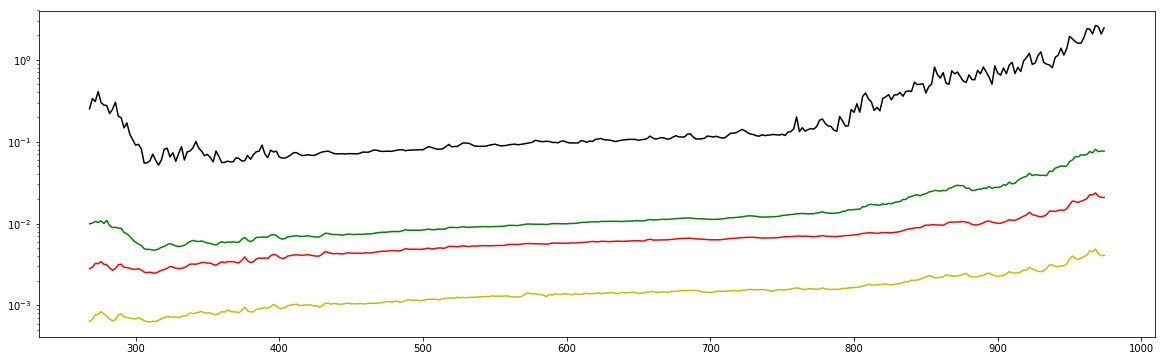

In [74]:
ax = spectral_df.dropna(how='any').median().plot(figsize=[20,6],c='r')
spectral_df.dropna(how='any').mean().plot(ax=ax,c='g')
spectral_df.dropna(how='any').min().plot(ax=ax,c='y')
(spectral_df.dropna(how='any').max()/10).plot(ax=ax,c='black')
ax.set_yscale('log')

In [44]:
spectral_df.dropna(how='any').sample(10)
# plot(figsize=[20,6])

,268,270,272,274,276,278,280,282,284,286,...,956,958,960,962,964,966,968,970,972,974
natural_index,,,,,,,,,,,,,,,,,,,,,
63314,0.142127,0.171215,0.144867,0.129405,0.123478,0.118553,0.146263,0.136009,0.096627,0.107646,...,0.670083,0.846267,0.910276,0.905305,0.788122,0.722610,0.865373,0.766174,1.045505,1.036145
49753,0.001864,0.002229,0.001873,0.001768,0.002217,0.001959,0.001819,0.001705,0.001787,0.001919,...,0.013757,0.017555,0.013364,0.012949,0.013343,0.012858,0.018732,0.017374,0.014441,0.015794
47263,0.001237,0.001266,0.001515,0.001732,0.001982,0.001626,0.001442,0.001264,0.001077,0.001425,...,0.006777,0.007232,0.009415,0.010007,0.011932,0.008804,0.009701,0.009996,0.011713,0.011493
50314,0.001439,0.001748,0.001787,0.001958,0.002045,0.001786,0.001632,0.001402,0.001447,0.001400,...,0.010035,0.009342,0.009348,0.009813,0.013901,0.011085,0.011706,0.010107,0.009768,0.009367
11040,0.002778,0.002674,0.003027,0.002473,0.003084,0.002946,0.002535,0.002303,0.002224,0.002351,...,0.016700,0.017451,0.018391,0.017662,0.017837,0.017128,0.019586,0.020494,0.018497,0.016760
51998,0.002633,0.002186,0.002228,0.002611,0.002711,0.002500,0.002243,0.002282,0.002482,0.002748,...,0.014170,0.013846,0.016831,0.020489,0.026077,0.028752,0.024007,0.020049,0.018513,0.016929
7870,0.001509,0.001383,0.001489,0.001813,0.001478,0.001573,0.001336,0.001199,0.001197,0.001307,...,0.008053,0.008745,0.010794,0.014262,0.015415,0.013748,0.013015,0.009281,0.008518,0.008488
51444,0.001694,0.001648,0.002575,0.002278,0.001859,0.001800,0.001679,0.001810,0.001755,0.001716,...,0.009754,0.008693,0.010347,0.011840,0.018938,0.015570,0.014047,0.015047,0.014576,0.011534
28567,0.002167,0.002243,0.002700,0.002088,0.002121,0.002449,0.002355,0.001487,0.001308,0.001331,...,0.011161,0.011537,0.010664,0.011906,0.019897,0.015497,0.018783,0.015347,0.012111,0.011607


In [48]:
%time
eq_img = np.sort(spectral_df.dropna(how='any').values.T.ravel()).searchsorted(spectral_df.dropna(how='any').values.T)
# from skimage import exposure
# # Equalization
# img_eq = exposure.equalize_hist(img)

# # Adaptive Equalization
# img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


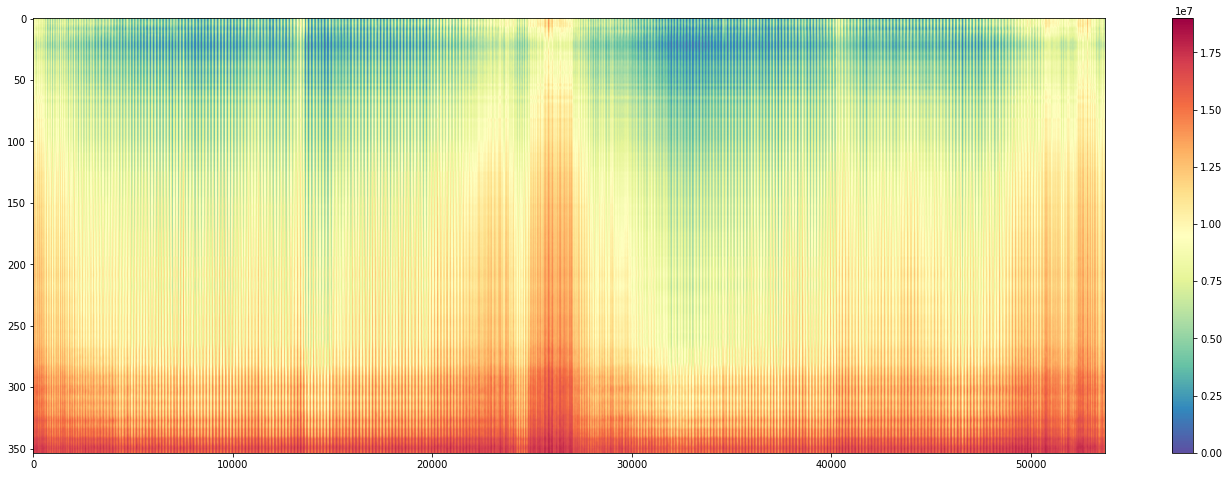

In [55]:
# image his equalisation> https://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy
plt.figure(figsize=[24,8]);
plt.imshow(eq_img,
           interpolation='bicubic',
           aspect='auto',
           cmap=plt.cm.Spectral_r);
plt.colorbar()

# Use reflectance data

In [20]:
# define 2 wavelenght2 and calculate something 
wavelength = 750
wavelength_idx = find_nearest(wavelength)

wavelength2 = 350
wavelength2_idx = find_nearest(wavelength2)

outdf_gdf['refl'] = outdf_gdf['array'].apply(lambda x : np.nan if np.isnan(x).all() else x[wavelength_idx])

window = 10
# outdf_gdf['refl'] = outdf_gdf['array'].apply(lambda x: np.nan if np.isnan(x).all() else np.nanmean(x[wavelength2_idx-window:wavelength2_idx+window])/np.nanmean(x[wavelength_idx-window:wavelength_idx+window]))

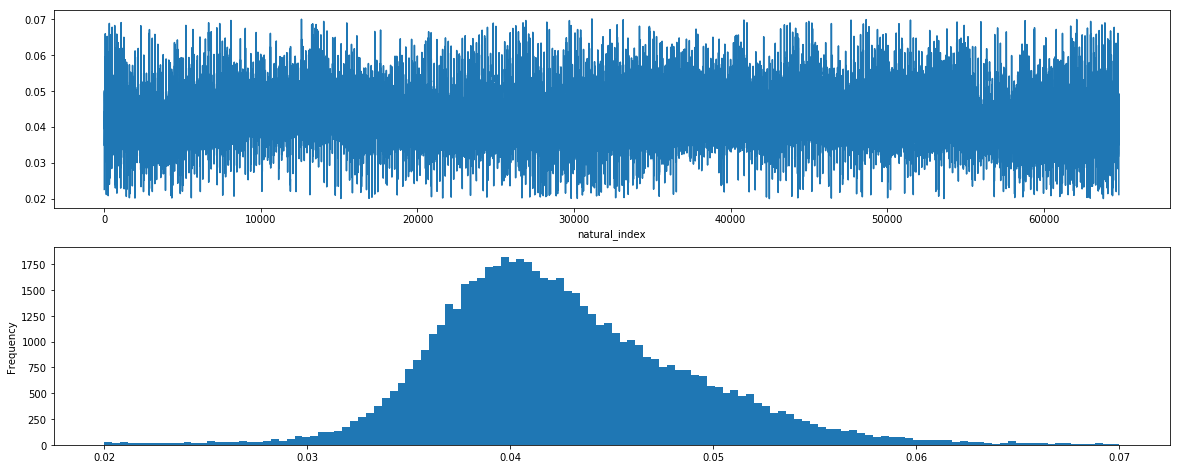

In [24]:
# cut some noisy data and plot the distribution 
f, ax = plt.subplots(nrows=2,ncols=1, figsize=[30,8])
# those values are use in the map plot below too
val_min, val_max = 0.02 , .07
plot_df = outdf_gdf.loc[(outdf_gdf['refl'] > val_min) & (outdf_gdf['refl'] < val_max),'refl']
plot_df.plot(ax=ax[0])
plot_df.plot(ax=ax[1],kind='hist',bins=128,figsize=[20,8],log=False)

In [13]:
extent = [outdf_gdf.total_bounds[i] for i in [0,2,1,3]]
extent

[-180.0, 180.0, -90.0, 90.0]

# Visualise the Data

Here we are using a trick : the regular grid is a 1D list, but could be casted to a 2D numpy array, knowing the size and given the `natural order` of the cell is respected.

This is were the `natural_index` in the Db comes in play: the Primary Key index are random incremental integer, the `natural_index` is assigned from me to respect the casting to 2D aArray.

Pro:

- quicker
- allows for image interpolation (nicer)

/user/mars/damo_ma/.conda/envs/gdal/lib/python3.5/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0
/user/mars/damo_ma/.conda/envs/gdal/lib/python3.5/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/user/mars/damo_ma/.conda/envs/gdal/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


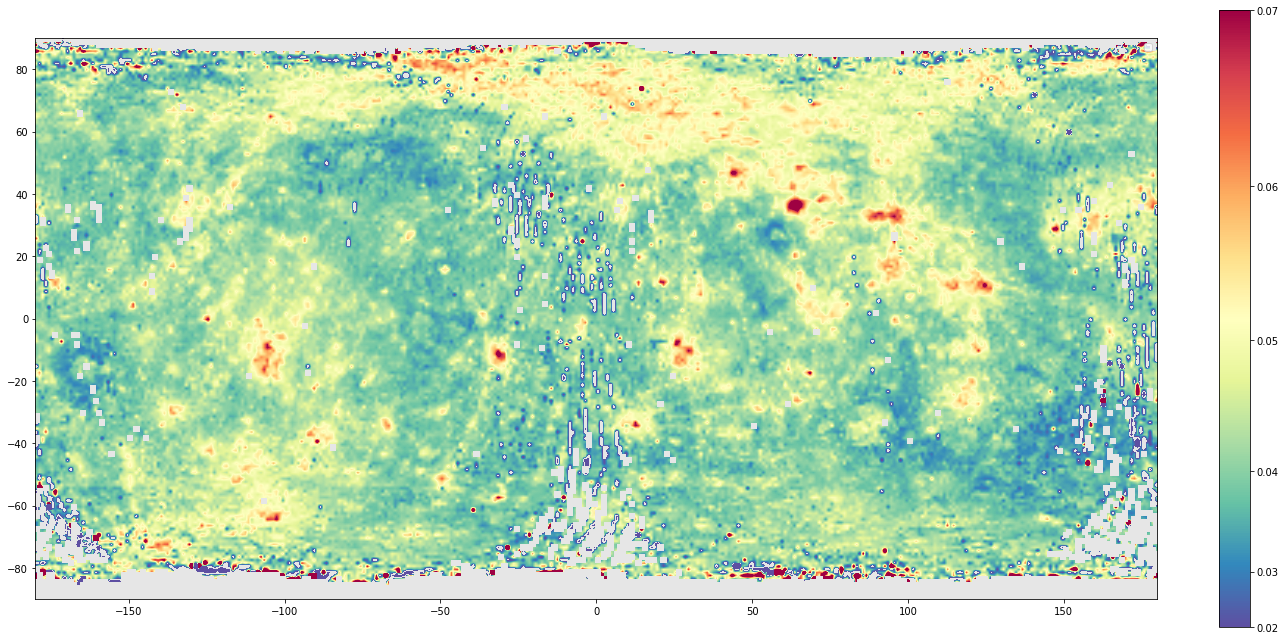

In [14]:
# here we are using matplotlib

# bend the colormap
import copy
my_cmap = copy.copy(plt.cm.Spectral_r) # copy the cmap
# my_cmap.set_over('b', 1.0)
my_cmap.set_under('black', 0.1)
my_cmap.set_bad('black', 0.1)

# make a figure
plt.figure(figsize=[18,9])
# Here we are using the numpy reshape because we now the final image shape: it is not always the case!!
# This is FASTER then Geopandas.GeoDataFrame.plot!!!!
plt.imshow(outdf_gdf.sort_index()['refl'].values.reshape(360,180).T,
           interpolation= 'bilinear',
           extent= extent,
           # you can skip this, it is to bend the colormap see https://matplotlib.org/users/colormapnorms.html
           norm=matplotlib.colors.PowerNorm(1.5,vmin=val_min,vmax=val_max),
           cmap=my_cmap);
plt.colorbar(fraction=0.04)
plt.legend('grid : {} / color : nm'.format(outfile,wavelength))
plt.tight_layout()
# plt.savefig(outfile,dpi=200)

/user/mars/damo_ma/.conda/envs/gdal/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


[(-90.0, 90.0), (-180.0, 180.0)]

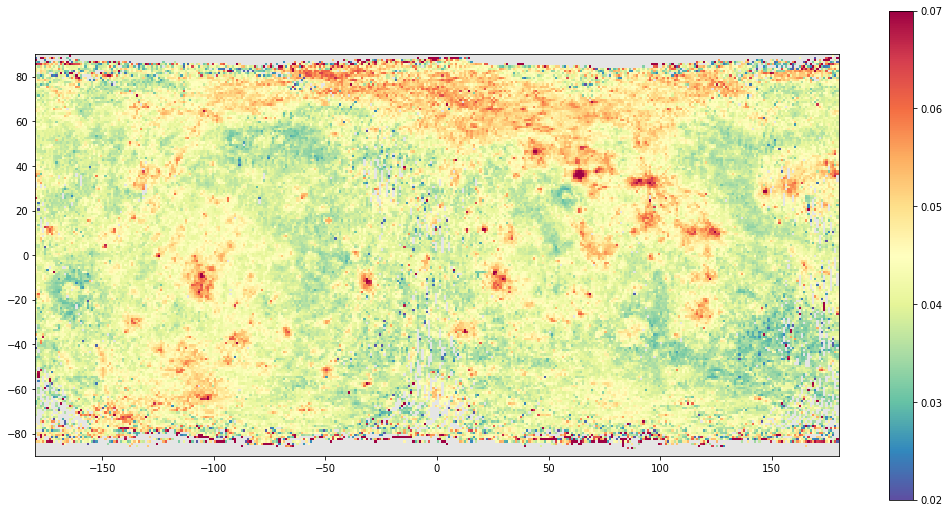

In [19]:
# here we are using geopandas, it is SLOW and you cannot use interpolation 
# bend the colormap
import copy
my_cmap = copy.copy(plt.cm.Spectral_r) # copy the cmap
# my_cmap.set_over('b', 1.0)
my_cmap.set_under('black', 0.1)
my_cmap.set_bad('black', 0.1)

vmin=-0.05
vmax=0.1
ax = outdf_gdf.plot(column='refl',figsize=[18,9], vmin=val_min,vmax=val_max, cmap=my_cmap, legend=True);
ax.set(xlim=[extent[0],extent[1]],ylim=[extent[2],extent[3]])

# Bonus : Effect of Matplotlib Normaliser

Text(0.5,1,'Histogram of Normalise(Refl Column)')

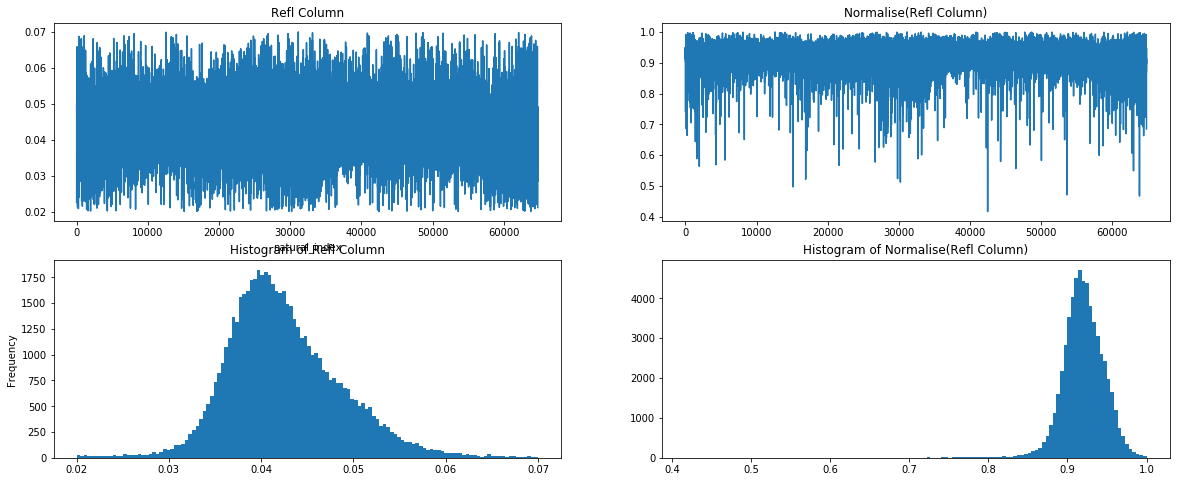

In [45]:
# cut some noisy data and plot the distribution 
f, axs = plt.subplots(nrows=2,ncols=2, figsize=[30,8])
ax = axs.flatten()
# those values are use in the map plot below too
val_min, val_max = 0.02 , .07
plot_df = outdf_gdf.loc[(outdf_gdf['refl'] > val_min) & (outdf_gdf['refl'] < val_max),'refl']
plot_df.plot(ax=ax[0])
ax[0].set_title('Refl Column')
plot_df.plot(ax=ax[2],kind='hist',bins=128,figsize=[20,8],log=False)
ax[2].set_title('Histogram of Refl Column')
norm = matplotlib.colors.PowerNorm(0.1,vmin=val_min,vmax=val_max)

ax[1].plot(plot_df.index.values,norm(plot_df.values))
ax[1].set_title('Normaliser(Refl Column)')
ax[3].hist(norm(plot_df.values),bins=128);
ax[3].set_title('Histogram of Normaliser(Refl Column)')